# Logistic Regression Mixture Model

Let $X_t \sim \mathcal{N}_{2}(0, I_{2}) $ (a random standard bivariate normal distribution), and the conditional distribution of $ Y_0 \mid X_0 = x $ follows a logistic model with true coefficients $\beta_0 = (\text{bias}_0, \text{weights}_0) $.

For iterative training, let $ Y_t \mid X_t $follow a logistic model with coefficients:

$$
\beta_t = (\text{bias}_t, \text{weights}_t) = \alpha_t \cdot \beta_0 + (1 - \alpha_t) \hat{\beta}_{t-1},
$$

where $ \hat{\beta}_{t-1} $ is the logistic regression estimate obtained from $(X_{t-1}, Y_{t-1})$.


In [15]:
from gettext import install

import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dist(b1, w1):
    # Euclidean distance for weights and biases
    return np.sqrt((bias0 - b1) ** 2 + np.sum((weights0 - w1) ** 2))

def plot_avg(loss, ax, plot_traces=True):
    mean = np.mean(loss, axis=0)
    var = np.var(loss, axis=0)
    if plot_traces:
        for i in range(len(loss)):
            ax.plot(range(loss.shape[1]), loss[i], color='yellow', alpha=0.1)
    ax.plot(range(loss.shape[1]), mean)

In [16]:
# Logistic Regression model
def logistic_fit(X, y, lr=0.01, num_iter=1000):
    # Initialize weights
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    
    # Gradient descent
    for i in range(num_iter):
        # Linear model
        linear_model = np.dot(X, weights) + bias
        # Apply sigmoid function
        y_pred = sigmoid(linear_model)
        
        # Calculate gradients
        dw = (1 / m) * np.dot(X.T, (y_pred - y))
        db = (1 / m) * np.sum(y_pred - y)
        
        # Update parameters
        weights -= lr * dw
        bias -= lr * db
        
        # Print loss every 100 iterations
        if i % 100 == 0:
            loss = -1 / m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            # print(f'Iteration {i}, Loss: {loss:.4f}')
    return weights, bias

In [17]:
# Parameters
T = 10
n0 = 500
weights = np.zeros((T, 2))
biases = np.zeros(T)

# Generate first stage data following a logistic model
np.random.seed(4209)
X0 = np.random.randn(n0, 2)
weights0 = np.array([2, -1])
bias0 = 0.5
model0 = np.dot(X0, weights0) + bias0
probs0 = sigmoid(model0)
y0 = (probs0 > 0.5).astype(int)
weights[0], biases[0] = logistic_fit(X0, y0, lr=0.01, num_iter=1000)

alpha0 = 0
c1, c2, c3, c4 = [1, 1, 0, 1]
d1, d2, d3, d4 = [0, 0, 0, 0]

for t in range(1, T):
    np.random.seed(4209)  # Change seed for variety across iterations
    nt = int(n0 + c1 * (t ** c2) + c3 * np.exp(c4 * t))  # Ensure nt is an integer
    alphat = alpha0 + d1 * (t ** d2) + d3 * np.exp(d4 * t)
    Xt = np.random.randn(nt, 2)
    weightst = alphat * weights0 + (1 - alphat) * weights[t - 1]
    biast = alphat * bias0 + (1 - alphat) * biases[t - 1]
    modelt = np.dot(Xt, weightst) + biast
    probst = sigmoid(modelt)
    yt = (probst > 0.5).astype(int)
    weights[t], biases[t] = logistic_fit(Xt, yt, lr=0.01, num_iter=1000)

In [18]:
weights0 = np.array([2, -1])
bias0 = 0.5
setting = [[1, 1, 0, 1],[0, 0, 0, 0]]
n0 = 500
alpha0= 0

def iterative_logistic(setting, T=100):
    c, d = setting
    weights = np.zeros((T, 2))
    biases = np.zeros(T)
    
    # Generate first stage data following a logistic model
    np.random.seed(4209)
    X0 = np.random.randn(n0, 2)
    model0 = np.dot(X0, weights0) + bias0
    probs0 = sigmoid(model0)
    y0 = (probs0 > 0.5).astype(int)
    weights[0], biases[0] = logistic_fit(X0, y0, lr=0.01, num_iter=1000)
    loss = [0]

    
    for t in range(1, T):
        np.random.seed(4209)  # Change seed for variety across iterations
        nt = int(n0 + c[0] * (t ** c[1]) + c[2] * np.exp(c[3] * t))  # Ensure nt is an integer
        alphat = alpha0 + d[0] * (t ** d[1]) + d[2] * np.exp(d[3] * t)
        Xt = np.random.randn(nt, 2)
        weightst = alphat * weights0 + (1 - alphat) * weights[t - 1]
        biast = alphat * bias0 + (1 - alphat) * biases[t - 1]
        modelt = np.dot(Xt, weightst) + biast
        probst = sigmoid(modelt)
        yt = (probst > 0.5).astype(int)
        weights[t], biases[t] = logistic_fit(Xt, yt, lr=0.01, num_iter=1000)
        loss.append(dist(biases[t-1], weights[t - 1]))
    
    return loss

In [19]:
from tqdm import tqdm
from joblib import Parallel, delayed

reps = 100
T=100
# Define 6 different settings
settings = [
    [[1, 1, 0, 0], [0, 0, 0, 0]],  # Setting 1
    [[1,2 , 0, 0], [0, 0, 0, 0]],  # Setting 2
    [[1, 1.5, 0, 0], [0, 0,0, 0]],  # Setting 3
    [[0, 0, 1, 0.001], [1, -2, 0, 0]],  # Setting 4
    [[0, 0, 0, 0], [0, 0, 1, 0.005]],  # Setting 5
    [[1, 2, 0, 0], [0, 0, 1, -0.005]]  # Setting 6
]

losses = np.zeros((len(settings), reps, T))

for i, setting in enumerate(settings):
    results = Parallel(n_jobs=-1)(delayed(iterative_logistic)(setting=setting, T=T) for j in range(reps))
    losses[i] = np.array([results[j] for j in tqdm(range(reps))])
    print(f'setting {i+1} done')

100%|██████████| 100/100 [00:00<00:00, 1671037.45it/s]


setting 1 done


100%|██████████| 100/100 [00:00<00:00, 1987821.80it/s]


setting 2 done


100%|██████████| 100/100 [00:00<00:00, 2291969.40it/s]


setting 3 done


100%|██████████| 100/100 [00:00<00:00, 2184533.33it/s]


setting 4 done


100%|██████████| 100/100 [00:00<00:00, 2173214.51it/s]


setting 5 done


100%|██████████| 100/100 [00:00<00:00, 2383127.27it/s]

setting 6 done


In [8]:
reps=500
T=100

# Parallel Execution
results = Parallel(n_jobs=-1)(delayed(iterative_logistic)(setting, T=T) for _ in tqdm(range(reps)))

# Collecting Results
losses = np.array(results)

ModuleNotFoundError: No module named 'tqdm'

In [11]:
pip install joblib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 301 kB 4.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


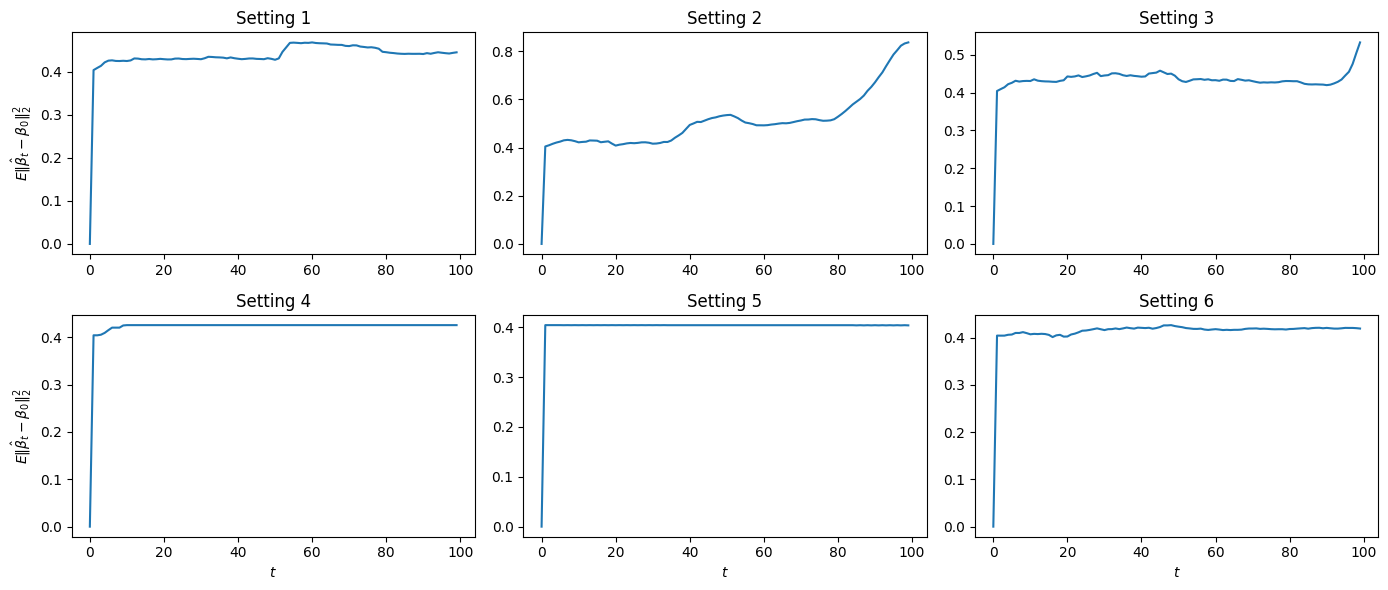

In [20]:
# Assuming `losses` is a list containing data for 6 settings.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))

for r in range(2):  # 2 rows
    for c in range(3):  # 3 columns
        idx = 3 * r + c  # Index for the losses list
        plot_avg(losses[idx], ax[r, c], plot_traces=False)  # Call your function
        ax[r, c].set_title(f'Setting {idx + 1}')  # Correct indexing for titles

# Set y-axis label for the first column of each row
ax[0, 0].set_ylabel('$E\\Vert \\hat{\\beta}_t - \\beta_0\\Vert_2^2$')
ax[1, 0].set_ylabel('$E\\Vert \\hat{\\beta}_t - \\beta_0\\Vert_2^2$')

# Set x-axis labels for the bottom row
for i in range(3):
    ax[1, i].set_xlabel('$t$')

plt.tight_layout()
plt.show()

In [9]:
import matplotlib.pyplot as plt

def plot_avg(loss, ax, plot_traces=True):
    """
    Plots the average loss and variance for one setting.
    
    Parameters:
    - loss: 2D array (reps, T), where `reps` is the number of repetitions and `T` is the time steps.
    - ax: Matplotlib axis object for plotting.
    - plot_traces: Boolean, if True, individual traces will be plotted in the background.
    """
    # Calculate mean and variance across repetitions
    mean = np.mean(loss, axis=0)
    var = np.var(loss, axis=0)

    # Plot individual traces if requested
    if plot_traces:
        for i in range(loss.shape[0]):  # Iterate over repetitions
            ax.plot(range(loss.shape[1]), loss[i], color='yellow', alpha=0.1)
    
    # Plot mean
    ax.plot(range(loss.shape[1]), mean, color='blue', label='Mean Loss')

    # Plot variance as shaded region
    ax.fill_between(range(loss.shape[1]), mean - var, mean + var, color='blue', alpha=0.2, label='Variance')

    # Add labels and legend
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Loss')
    ax.set_title('Average Loss and Variance')
    ax.legend()


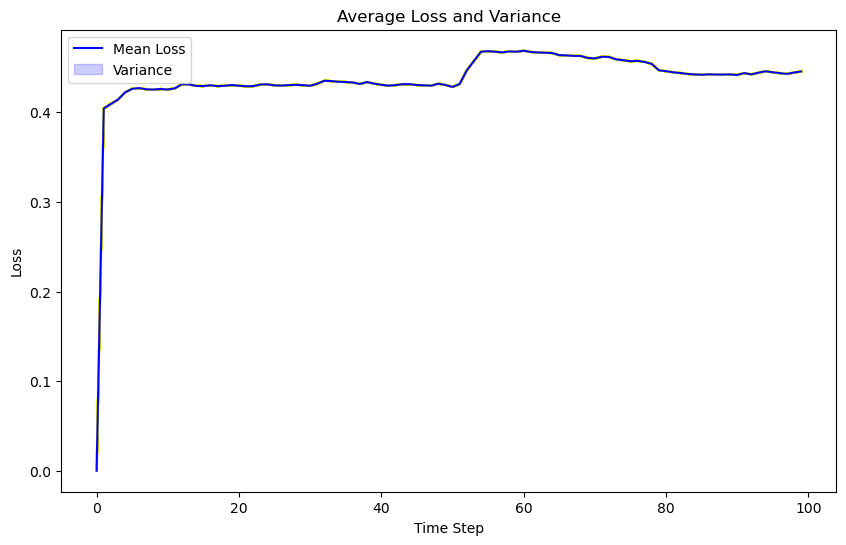